## Histogram of Oriented Gradient (HOG)
### Reading and listing Cars and NotCars images for Training
##### Unzip the vehiles and non-vehicles zip files from class then read throug and make a list in the txt files for both cars and notcars list.

In [1]:
import os
import glob

def read_n_list_data(cars_dir, notcars_dir):    

    # look into vehicles and non-vehicles folder to read in the images 
    # from GTI, Kitti and extra, other sub-folders     
    image_types = os.listdir(carsdir)
    cars = []
    for imtype in image_types:
        cars.extend(glob.glob(carsdir+imtype+'/*'))

    # print('Number of vehicle images found: ', len(cars))
    # write file names of images to cars.txt file 
    with open("cars.txt", 'w') as f:
        for fn in cars:
            f.write(fn+'\n')

    # for non-vehicle images    
    image_types = os.listdir(notcarsdir)
    notcars = []
    for imtype in image_types:
        notcars.extend(glob.glob(notcarsdir+imtype+'/*'))

    # print('Number of non vehicle images found: ', len(notcars))
    with open("notcars.txt", 'w') as f:
        for fn in notcars:
            f.write(fn+'\n')

    return cars, notcars

carsdir = 'vehicles/'
notcarsdir = 'non-vehicles/'
cars, notcars = read_n_list_data(carsdir, notcarsdir)
print('Number of vehicle images found: ', len(cars))
print('Number of non vehicle images found: ', len(notcars))

Number of vehicle images found:  8792
Number of non vehicle images found:  8968


##### Import neccessary packages

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

  warn(skimage_deprecation('The `skimage.filter` module has been renamed '



##### Display an example of car image and notcar image from the data

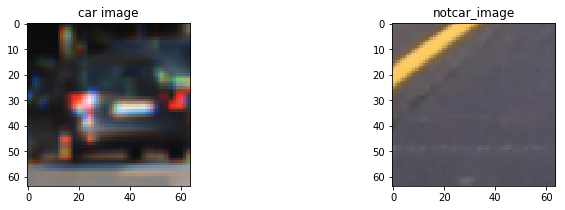

In [3]:
%matplotlib inline


def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

# fet random car and notcar index to visualize
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car/not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

images = [car_image, notcar_image]
titles = ['car image', 'notcar_image']
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 2, images, titles)


In [4]:
# get histogram of gradient (HOG) features and visualization
# params: img - input image
# orient: orientation in int - number of oreintation in bins
# pix_per_cell: size (in pixel) of a cell
# cell_per_block - 2 tuple (int, int) - number of celss in each block
# vis - bool - whether return of the HOG image
# feature_vec - bool - return data as feature vector by calling .ravel()
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

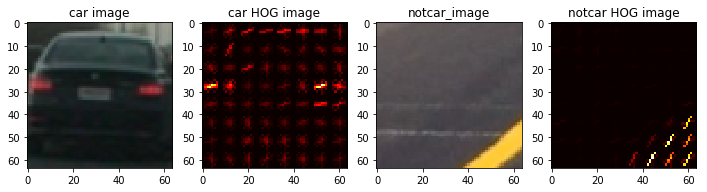

In [5]:
# Choose random car/not-car indices
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car/not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Define feature parameter
orient = 9
pix_per_cell = 8
cell_per_block = 2

# convert color 
car_feature_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)
notcar_feature_image = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2YCrCb)

car_features, car_hog_image = get_hog_features(car_feature_image[:,:,2],
                                            orient, pix_per_cell, cell_per_block,
                                            vis=True, feature_vec=True)
notcar_features, notcar_hog_image = get_hog_features(notcar_feature_image[:,:,2],
                                            orient, pix_per_cell, cell_per_block,
                                            vis=True, feature_vec=True)
images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
titles = ['car image', 'car HOG image', 'notcar_image', 'notcar HOG image']
fig = plt.figure(figsize=(12,3))
visualize(fig, 1, 4, images, titles)


##### Utility Functions

In [6]:
# Color features
# Computing binned color features - spatial binning
# params: img - image input 
# size - resolution to be scaled down
def bin_spatial(img, size=(32,32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    # features = cv2.resize(img, size).ravel()
    # return features
    return np.hstack((color1, color2, color3))


# Computing color histogram features
# params: img - image input
# nbins - number of bins
# bins_range - the range of the bins. depends on how image is read in
# the range needs to be adjusted.
# if png image and read in with mpimg, the range needs to be changed
def color_hist(img, nbins=32): # bins_range=(0, 256) for jpeg
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


# extracting the features from single image window
# params: img - image input
# color_space - what color space do you want to extract features from
# spatial_size - the size to be reduced to extract spatial binning
# hist_bins - number bins for color histogram features
# pix_per_cell: size (in pixel) of a cell
# cell_per_block - 2 tuple (int, int) - number of celss in each block 
# hog_channel - 0, 1, 2 or "ALL"
# spatial_feat - True to extract or False not extract spatial binning feature
# hist_feat - True to extract or Fals not to extract color histogram feature
# hog_feat - True to extract or False not to extract hog feature
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis=False):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True)) 
            
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel],
                                                          orient, pix_per_cell, cell_per_block,
                                                          vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                                orient, pix_per_cell, cell_per_block, 
                                                vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        return np.concatenate(img_features)


##### Training the Classifier (LinearSVC)

In [7]:
# train LinearSVC classifier
# params: test_cars - cars data images
# test_notcars - notcars data images
# color_space - RGB, HSV, HLS, LUV, YCrCb
# orient - orientation of HOG
# pix_per_cell - how many pixels per cell
# cell_per_block - how many cells per a block
# hog_channel - how many channels for the hog feature - 0, 1, 2, "ALL"
# spatial_size - spaitail binning size
# hist_bins - the number of bins for the color historgram
# spatial_feat - boolean - True for including
# hist_feat - boolean - True for including
# hog_feat - boolean - True for including
# test_size - the size to split as the test data
# return - classifier
def train_vehicle_detection_classifier(test_cars, test_notcars, 
                                       color_space='RGB', oreint=9, pix_per_cell=8,
                                       cell_per_block=2, hog_channel=0, spatial_size=(32,32),
                                       hist_bins=32, spatial_feat=True, hist_feat=True,
                                       hog_feat=True, test_size=0.1):
    
    # for the time stamp
    t = time.time()

    car_features = extract_features(test_cars, color_space='YCrCb',
                                    spatial_size= spatial_size, hist_bins=hist_bins,
                                    orient=orient, pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block,
                                    hog_channel='ALL', spatial_feat= spatial_feat,
                                    hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(test_notcars, color_space='YCrCb',
                                    spatial_size= spatial_size, hist_bins=hist_bins,
                                    orient=orient, pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block,
                                    hog_channel='ALL', spatial_feat= spatial_feat,
                                    hist_feat=hist_feat, hog_feat=hog_feat)

    print(time.time()-t, 'Seconds to compute features...')

    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector to be 1's for cars and 0's for not cars
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=test_size, random_state=rand_state)

    print('Using: ', orient, 'orientations', pix_per_cell, 'pixels per cell',
          cell_per_block, 'cells per block', hist_bins, 'histogram bins', spatial_size, 'spatial sampling')
    print('Feature vector length: ', len(X_train[0]))

    # Use LinearSVC
    svc = LinearSVC()

    # time stamps
    t = time.time()
    svc.fit(X_train, y_train)
    print(round(time.time()-t, 2), 'Seconds to train SVC...')
    # check the test score
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    
    return svc, X_scaler
    

In [8]:
# Define featutre parameters
color_space = 'YCrCb'
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
hist_bins = 32
spatial_feat = True
hist_feat = True
hog_feat = True
test_size = 0.1

clf, scaler = train_vehicle_detection_classifier(cars, notcars, 
                                                color_space=color_space, oreint=orient, 
                                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                                hog_channel=hog_channel, spatial_size=spatial_size,
                                                hist_bins=hist_bins, spatial_feat=spatial_feat, 
                                                hist_feat=hist_feat, hog_feat=hog_feat, 
                                                test_size=test_size)

# store the classifier in pickle file which will be used later
joblib.dump(clf, 'classifer.pkl')
joblib.dump(scaler, 'scaler.pkl')

89.71906399726868 Seconds to compute features...
Using:  9 orientations 8 pixels per cell 2 cells per block 32 histogram bins (32, 32) spatial sampling
Feature vector length:  8460
31.23 Seconds to train SVC...
Test Accuracy of SVC =  0.9949


['scaler.pkl']

##### Sliding and Searching Window

In [9]:
# Slide the window of xy_window size with overlapped size 
# of xy_overlap from the img x_start_stop, y_start_stop to 
# the whole img area
# params: img - image that needs to be cut into small windows
# x_start_stop - start and end x coordinates of the image to cut
# y_start_stop - start and end y coordinates of the image to cut
# xy_window - size of small cut window
# xy_overlap - the overlap factor for each small window
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
# searching whether cars are in the small windows that cut 
# with slide_window() function
# params: img - image to be searched through
# windows - list of windows that cut into by slide_window()
# clf - trained classifier
# scaler - scaler that used while in training
# color_space - RGB, HSV, HLS, LUV, YCrCb
# spatial_size - spaitail binning size
# hist_bins - the number of bins for the color historgram
# hist_range - the range for histogram
# orient - orientation of HOG
# pix_per_cell - how many pixels per cell
# cell_per_block - how many cells per a block
# hog_channel - how many channels for the hog feature - 0, 1, 2, "ALL"
# spatial_feat - boolean - True for including
# hist_feat - boolean - True for including
# hog_feat - boolean - True for including 

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

# Drawing the bounding boxes on the copy of the input image
# params: img - original image
# bboxes - windows that found cars
# color - color to draw boxes
# thick - thickness of the boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


##### Drawing Bounding Boxes on the test images using sliding and searching window - 1st pass

0.0 1.0
0.4730050563812256  seconds to process one image searching 100 windows
0.0 1.0
0.44458913803100586  seconds to process one image searching 100 windows
0.0 1.0
0.5107951164245605  seconds to process one image searching 100 windows
0.0 1.0
0.45084500312805176  seconds to process one image searching 100 windows
0.0 1.0
0.44554591178894043  seconds to process one image searching 100 windows
0.0 1.0
0.4279360771179199  seconds to process one image searching 100 windows


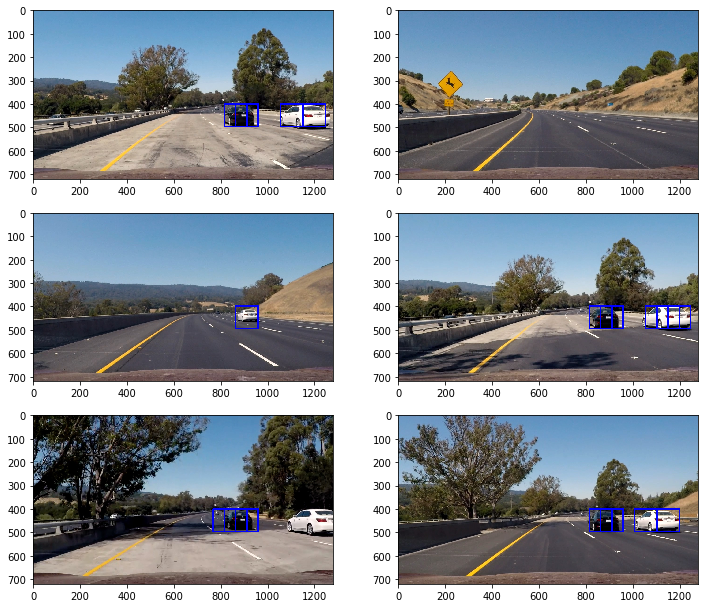

In [10]:
searchpath = 'test_images/*' # 'images_video/vehicle_det_examples/*'
example_images = glob.glob(searchpath)
images = []
titles = []
y_start_stop = [400, 656]
overlap = 0.5
# read in the classifier and scaler from the training step
svc = joblib.load('classifer.pkl')
X_scaler = joblib.load('scaler.pkl')

for img_src in example_images:
    t1 = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    
    img = img.astype(np.float32)/255 # for jpeg - scale to png scale 0 to 1
    print(np.min(img), np.max(img))
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                           xy_window=(96,96), xy_overlap=(overlap,overlap))
    
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block, 
                                 hog_channel=hog_channel, spatial_feat=spatial_feat,
                                 hist_feat=hist_feat, hog_feat=hog_feat)
    
    window_img = draw_boxes(draw_img, hot_windows, color=(0, 0, 255), thick=6)
    images.append(window_img)
    titles.append('')
    print(time.time()-t1, ' seconds to process one image searching', len(windows), 'windows')
fig = plt.figure(figsize=(12,18), dpi=300)
visualize(fig, 5, 2, images, titles)

##### Implementation from the techniques that discussed in Youtube - Udacity CarND Project 5 by Ryan Keenan

In [11]:
def find_cars(img, scale=1, ystart=400, ystop=656,  
              window=64, orient=9, pix_per_cell=8, cell_per_block=2):
    
    count = 0
    # make a copy of original image
    draw_img = np.copy(img)
    # initialize the heatmap with zeros
    heatmap = np.zeros_like(img[:,:,0])
    # for jpeg - scale to png scale 0 to 1
    img = img.astype(np.float32)/255 
    
    # region of interest image 
    img_tosearch = img[ystart:ystop,:,:]
    # convert the color to be YCrCb
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    
    # if the scale is not 1 then resize
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # color channel
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # number cells in the region - x and y blocks
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    # number of features per blocks
    nfeat_per_block = orient * cell_per_block**2
    
    # number of blocks per window
    nblocks_per_window = (window // pix_per_cell) - 1
    
    # cells to step through instead of overlapping
    cells_per_step = 2 
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # compute hog features per channel
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            count += 1
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # extract hog feature 
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get Color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))
            test_prediction = svc.predict(test_features)
            
            # check if prediction is good then draw boxe on the draw_img and add in heatmap
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart), 
                              (xbox_left+window, ytop_draw+win_draw+ystart),
                              (0, 0, 255), 6)
                # add boxes to the deque
                #img_boxes.append(((xbox_left, ytop_draw+ystart),
                #                  (xbox_left+win_draw, ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
    
    return heatmap

##### thresholding, heatmap, labeling

In [12]:
def apply_threshold(heatmap, threshold):
    #zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # return the thresholded map
    return heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

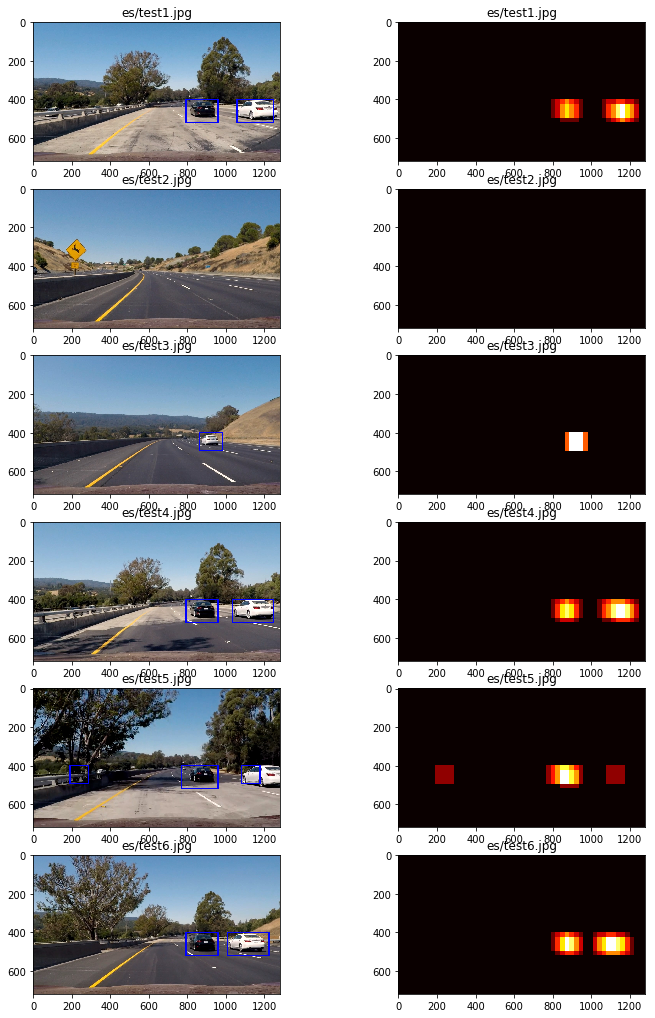

In [13]:
out_images = []
out_maps = []
out_titles = []
ystart = 400
ystop = 656
scale = 1.5
window = 64
orient = 9
pix_per_cell = 8
cell_per_block = 2
searchpath = 'test_images/*' 
example_images = glob.glob(searchpath)

# Iterate over test images
for img_src in example_images:
    img = mpimg.imread(img_src)
    heat_map = find_cars(img, scale,
                                  ystart, ystop, 
                                  window, orient, 
                                  pix_per_cell, cell_per_block)
    labels = label(heat_map)
    # Draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    out_images.append(draw_img)
    out_images.append(heat_map)
    out_titles.append(img_src[-12:])
    out_titles.append(img_src[-12:])

fig = plt.figure(figsize=(12,24))
visualize(fig, 8,2, out_images, out_titles)

##### Video Implementation

In [14]:
def process_img(img):
    heat_map = find_cars(img, scale)
    heat_map = apply_threshold(heat_map, 1)
    labels = label(heat_map)
    # draw bounding boxes on a copy of the image
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img

In [15]:
# video read in and process frame by frame
test_output = 'test_video_out.mp4'
# test_output = 'project_video_out.mp4'
clip = VideoFileClip("test_video.mp4")
# clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process_img)
test_clip.write_videofile(test_output, audio=False)

  self.nchannels))



[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:13<00:00,  2.87it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 



In [16]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(test_output))

In [17]:
# video read in and process frame by frame
project_output = 'project_video_out.mp4'
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process_img)
test_clip.write_videofile(project_output, audio=False)

  self.nchannels))



[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [08:15<00:00,  2.68it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 



In [18]:
HTML("""
<video width="960" height="540" controls>
    <source src="{0}">
</video>
""".format(project_output))